
# Quantile regression

This example illustrates how quantile regression can predict non-trivial
conditional quantiles.

The left figure shows the case when the error distribution is normal,
but has non-constant variance, i.e. with heteroscedasticity.

The right figure shows an example of an asymmetric error distribution,
namely the Pareto distribution.


In [1]:
# Authors: David Dale <dale.david@mail.ru>
#          Christian Lorentzen <lorentzen.ch@gmail.com>
#          Guillaume Lemaitre <glemaitre58@gmail.com>
# License: BSD 3 clause

## Dataset generation

To illustrate the behaviour of quantile regression, we will generate two
synthetic datasets. The true generative random processes for both datasets
will be composed by the same expected value with a linear relationship with a
single feature `x`.



In [16]:
import numpy as np

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=2000)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

We will create two subsequent problems by changing the distribution of the
target `y` while keeping the same expected value:

- in the first case, a heteroscedastic Normal noise is added;
- in the second case, an asymmetric Pareto noise is added.



In [17]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

Let's first visualize the datasets as well as the distribution of the
residuals `y - mean(y)`.



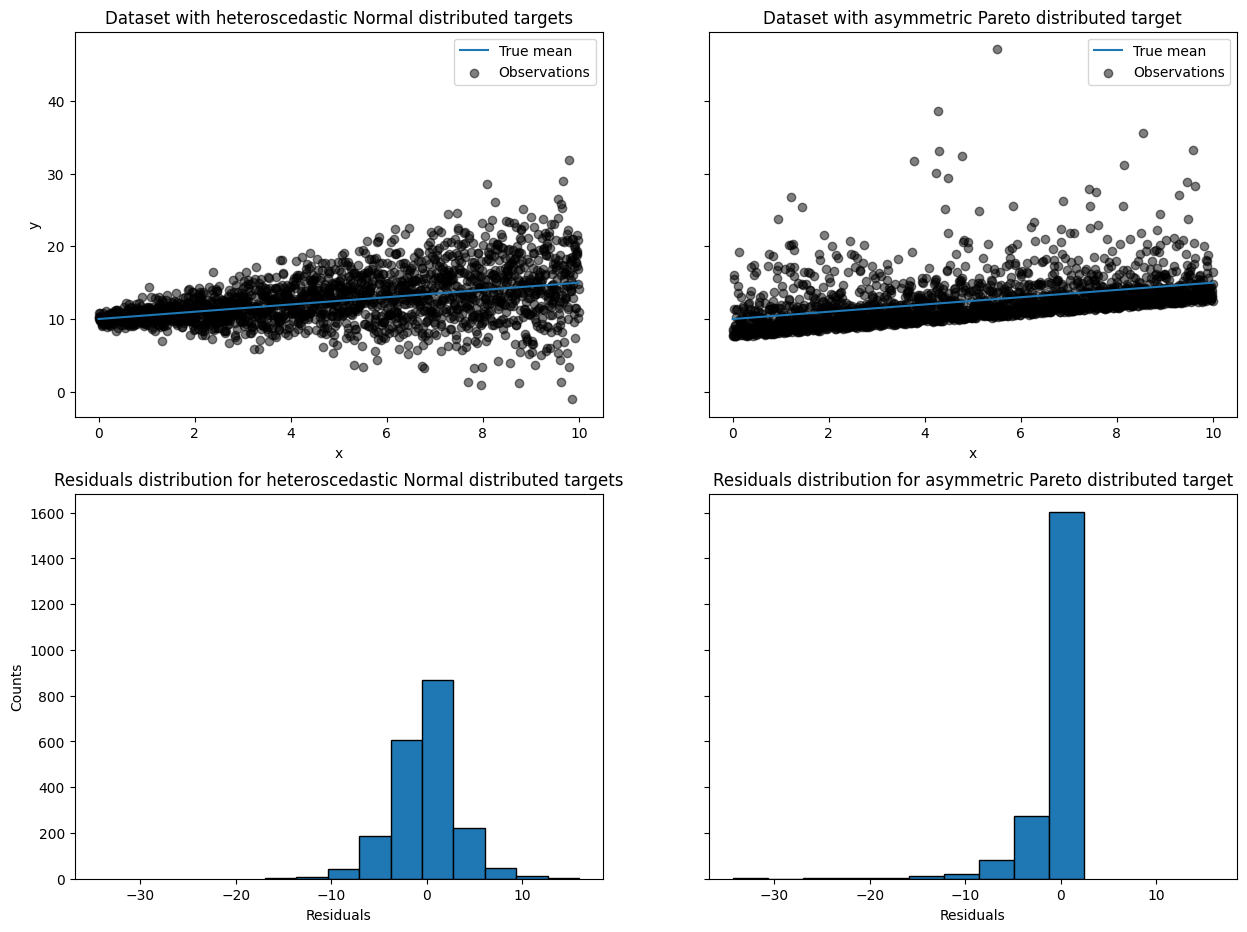

In [18]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

With the heteroscedastic Normal distributed target, we observe that the
variance of the noise is increasing when the value of the feature `x` is
increasing.

With the asymmetric Pareto distributed target, we observe that the positive
residuals are bounded.

These types of noisy targets make the estimation via
:class:`~sklearn.linear_model.LinearRegression` less efficient, i.e. we need
more data to get stable results and, in addition, large outliers can have a
huge impact on the fitted coefficients. (Stated otherwise: in a setting with
constant variance, ordinary least squares estimators converge much faster to
the *true* coefficients with increasing sample size.)

In this asymmetric setting, the median or different quantiles give additional
insights. On top of that, median estimation is much more robust to outliers
and heavy tailed distributions. But note that extreme quantiles are estimated
by very few data points. 95% quantile are more or less estimated by the 5%
largest values and thus also a bit sensitive outliers.

In the remainder of this tutorial, we will show how
:class:`~sklearn.linear_model.QuantileRegressor` can be used in practice and
give the intuition into the properties of the fitted models. Finally,
we will compare the both :class:`~sklearn.linear_model.QuantileRegressor`
and :class:`~sklearn.linear_model.LinearRegression`.

## Fitting a `QuantileRegressor`

In this section, we want to estimate the conditional median as well as
a low and high quantile fixed at 5% and 95%, respectively. Thus, we will get
three linear models, one for each quantile.

We will use the quantiles at 5% and 95% to find the outliers in the training
sample beyond the central 90% interval.



In [19]:
from sklearn.utils.fixes import parse_version, sp_version

# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [20]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05,0.25, 0.5,0.75, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

Now, we can plot the three linear models and the distinguished samples that
are within the central 90% interval from samples that are outside this
interval.



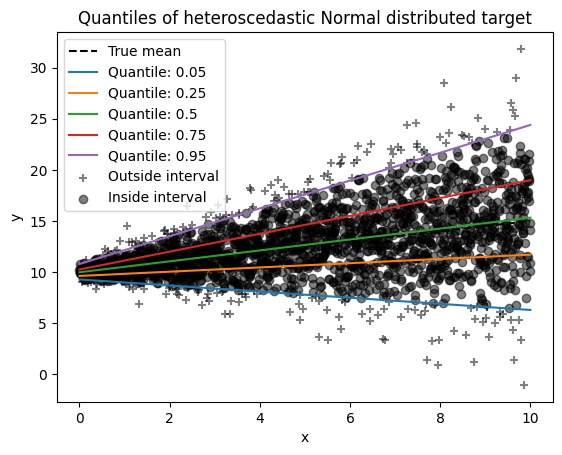

In [21]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

Since the noise is still Normally distributed, in particular is symmetric,
the true conditional mean and the true conditional median coincide. Indeed,
we see that the estimated median almost hits the true mean. We observe the
effect of having an increasing noise variance on the 5% and 95% quantiles:
the slopes of those quantiles are very different and the interval between
them becomes wider with increasing `x`.

To get an additional intuition regarding the meaning of the 5% and 95%
quantiles estimators, one can count the number of samples above and below the
predicted quantiles (represented by a cross on the above plot), considering
that we have a total of 100 samples.

We can repeat the same experiment using the asymmetric Pareto distributed
target.



In [22]:

quantiles = [0.05,0.25, 0.5,0.75, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )

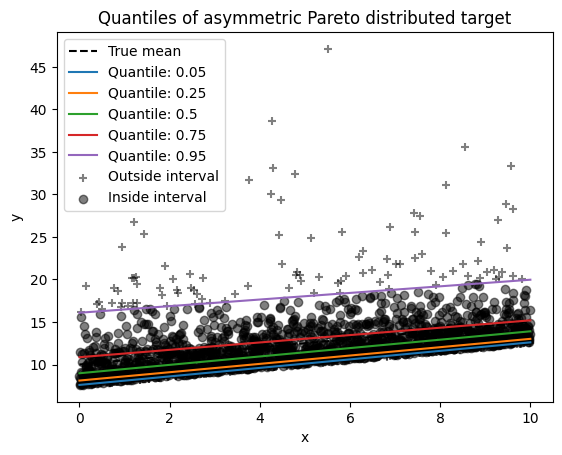

In [23]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

Due to the asymmetry of the distribution of the noise, we observe that the
true mean and estimated conditional median are different. We also observe
that each quantile model has different parameters to better fit the desired
quantile. Note that ideally, all quantiles would be parallel in this case,
which would become more visible with more data points or less extreme
quantiles, e.g. 10% and 90%.

## Comparing `QuantileRegressor` and `LinearRegression`

In this section, we will linger on the difference regarding the error that
:class:`~sklearn.linear_model.QuantileRegressor` and
:class:`~sklearn.linear_model.LinearRegression` are minimizing.

Indeed, :class:`~sklearn.linear_model.LinearRegression` is a least squares
approach minimizing the mean squared error (MSE) between the training and
predicted targets. In contrast,
:class:`~sklearn.linear_model.QuantileRegressor` with `quantile=0.5`
minimizes the mean absolute error (MAE) instead.

Let's first compute the training errors of such models in terms of mean
squared error and mean absolute error. We will use the asymmetric Pareto
distributed target to make it more interesting as mean and median are not
equal.



In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0, solver=solver)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

print(
    f"""Training error (in-sample performance)
    {linear_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_lr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_lr):.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_qr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_qr):.3f}
    """
)

Training error (in-sample performance)
    LinearRegression:
    MAE = 1.945
    MSE = 9.079
    QuantileRegressor:
    MAE = 1.776
    MSE = 9.986
    


On the training set, we see that MAE is lower for
:class:`~sklearn.linear_model.QuantileRegressor` than
:class:`~sklearn.linear_model.LinearRegression`. In contrast to that, MSE is
lower for :class:`~sklearn.linear_model.LinearRegression` than
:class:`~sklearn.linear_model.QuantileRegressor`. These results confirms that
MAE is the loss minimized by :class:`~sklearn.linear_model.QuantileRegressor`
while MSE is the loss minimized
:class:`~sklearn.linear_model.LinearRegression`.

We can make a similar evaluation by looking at the test error obtained by
cross-validation.



In [25]:
from sklearn.model_selection import cross_validate

cv_results_lr = cross_validate(
    linear_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = cross_validate(
    quantile_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(
    f"""Test error (cross-validated performance)
    {linear_regression.__class__.__name__}:
    MAE = {-cv_results_lr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_lr["test_neg_mean_squared_error"].mean():.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {-cv_results_qr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_qr["test_neg_mean_squared_error"].mean():.3f}
    """
)

Test error (cross-validated performance)
    LinearRegression:
    MAE = 1.965
    MSE = 9.089
    QuantileRegressor:
    MAE = 1.776
    MSE = 9.991
    


We reach similar conclusions on the out-of-sample evaluation.



### Quantile Regression

#### Concept

Quantile Regression is a type of regression analysis used to estimate the conditional quantiles (such as the median or percentiles) of the response variable. Unlike Ordinary Least Squares (OLS) regression, which estimates the mean of the dependent variable given the independent variables, quantile regression aims to estimate the median or other quantiles of the dependent variable. This makes it particularly useful for understanding the distributional effects and for dealing with heteroscedasticity or outliers in the data.

#### Mathematical Formulation

In quantile regression, the goal is to estimate the conditional quantile function:

$\
Q_y(\tau | \vec{x}) = \vec{x}^T \beta_\tau
$

where:
- $\ \tau $ is the quantile of interest (e.g., 0.5 for the median).
- $\ \vec{x} $ is the feature vector.
- $\ \beta_\tau $ is the vector of coefficients for quantile $\ \tau $.

The objective function to minimize is:

$\
\min_{\beta_\tau} \sum_{i=1}^{n} \rho_\tau(y_i - \vec{x}_i^T \beta_\tau)
$

where $\  \rho_\tau  $ is the quantile loss function defined as:

$\
\rho_\tau(u) = u(\tau - \mathbf{1}_{u < 0})
$

This function gives different weights to positive and negative residuals, which allows for the estimation of different quantiles.

#### Fitting the Model

To fit a quantile regression model using a dataset $\ (\vec{x}_i, y_i) $, the following steps are typically taken:

1. **Initialization**:
   - Choose the quantile $\ \tau $ to estimate.
   - Initialize the coefficients $\ \beta_\tau $.

2. **Optimization**:
   - Use linear programming or iterative optimization techniques to minimize the quantile loss function $\ \sum_{i=1}^{n} \rho_\tau(y_i - \vec{x}_i^T \beta_\tau) $.

3. **Iteration**:
   - Iterate until convergence, updating $\ \beta_\tau $ at each step to reduce the loss function.

#### Comparison with Ordinary Least Squares (OLS)

**Ordinary Least Squares (OLS)**:
- **Objective**: Minimizes the sum of squared residuals.
- **Mathematical Formulation**:
  $\
  \min_{\beta} \sum_{i=1}^{n} (y_i - \vec{x}_i^T \beta)^2
  $
- **Estimates**: The mean of the conditional distribution of the response variable.
- **Sensitivity**: Sensitive to outliers and assumes homoscedasticity (constant variance of errors).

**Quantile Regression**:
- **Objective**: Minimizes the weighted sum of absolute residuals based on the quantile of interest.
- **Mathematical Formulation**:
  $\
  \min_{\beta_\tau} \sum_{i=1}^{n} \rho_\tau(y_i - \vec{x}_i^T \beta_\tau)
  $
- **Estimates**: The conditional quantiles (e.g., median, percentiles) of the response variable.
- **Sensitivity**: Robust to outliers and does not assume homoscedasticity. Can model the conditional distribution more comprehensively.

#### Advantages of Quantile Regression

- **Robustness to Outliers**: Provides a more robust estimate in the presence of outliers compared to OLS.
- **Heteroscedasticity**: Effective in dealing with heteroscedastic data where the variance of the errors is not constant.
- **Distributional Analysis**: Allows for a comprehensive analysis of the conditional distribution of the response variable by estimating different quantiles.

#### Disadvantages of Quantile Regression

- **Complexity**: The optimization problem can be more complex and computationally intensive than OLS.
- **Interpretation**: Interpretation of the coefficients can be less straightforward compared to OLS.

### Example Usage in Sklearn

Currently, scikit-learn does not provide a direct implementation for quantile regression, but you can use the `statsmodels` library for this purpose. Here’s an example:

```python
import numpy as np
